### Setup

In [1]:
!pip install -q datasets


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from datasets import load_dataset_builder
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import re
import time

%matplotlib inline

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
E0000 00:00:1753934551.457567      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


In [3]:
try:
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    strategy = tf.distribute.TPUStrategy(cluster_resolver)
    print("Using Tpu")
except:
    if tf.config.list_physical_devices('GPU'):
        strategy = tf.distribute.MirroredStrategy()
        print('Using GPU')
    else:
        strategy = tf.distribute.get_strategy()
        print("Using CPU")

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


I0000 00:00:1753934571.486122      10 service.cc:148] XLA service 0x57b831564670 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753934571.486167      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1753934571.486171      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1753934571.486175      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1753934571.486177      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1753934571.486180      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1753934571.486182      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1753934571.486185      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1753934571.486188      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

### Download the dataset

In [4]:
dataset_path = "9wimu9/ada_derana_sinhala"
ds_builder = load_dataset_builder(dataset_path)

In [5]:
print(ds_builder.info)

DatasetInfo(description='', citation='', homepage='', license='', features={'id': Value('int64'), 'heading': Value('string'), 'content': List(Value('string'))}, post_processed=None, supervised_keys=None, builder_name='parquet', dataset_name='ada_derana_sinhala', config_name='default', version=0.0.0, splits={'train': SplitInfo(name='train', num_bytes=418940569, num_examples=170420, shard_lengths=None, dataset_name=None)}, download_checksums=None, download_size=159392910, post_processing_size=None, dataset_size=418940569, size_in_bytes=None)


In [6]:
print(ds_builder.info.splits)

{'train': SplitInfo(name='train', num_bytes=418940569, num_examples=170420, shard_lengths=None, dataset_name=None)}


In [7]:
from datasets import load_dataset
from pathlib import Path

cache_dir = "./dataset/cache"
Path(cache_dir).mkdir(parents=True, exist_ok=True)
dataset = load_dataset(dataset_path, cache_dir=cache_dir)

Generating train split: 100%|██████████| 170420/170420 [00:01<00:00, 142538.60 examples/s]


In [8]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'heading', 'content'],
        num_rows: 170420
    })
})


In [9]:
raw_ds = dataset['train']
print(raw_ds)

Dataset({
    features: ['id', 'heading', 'content'],
    num_rows: 170420
})


### Process the text

In [10]:
content = raw_ds[:-1]["content"]
print(f"Total number of rows in the raw dataset: {len(content)}")

Total number of rows in the raw dataset: 170419


In [11]:
def create_1d_list(n_d_list: list[list[str]]) -> list[str]:
    one_d_list = []
    for row in n_d_list:
        if len(row) > 1:
            for sub_row in row:
                one_d_list.append(sub_row)
        elif len(row) == 0:
            pass
        else:
            one_d_list.append(row[0])
    return one_d_list

In [12]:
text_list = create_1d_list(content)
print(f"Total number of paragraphs: {len(text_list)}")

Total number of paragraphs: 1048389


In [13]:
def get_value_counts(text: str, decode=False) -> dict:
    chars = tf.strings.unicode_split(text, input_encoding='UTF-8')
    values, counts = np.unique(chars, return_counts=True)
    counts = map(lambda x: int(x), counts)
    if decode:
        values = map(lambda x: x.decode('UTF-8'), values)
    value_counts = dict(zip(values, counts))
    sorted_value_counts = dict(sorted(value_counts.items(), key=lambda x: x[1], reverse=True))
    return sorted_value_counts

In [14]:
def clean_text(text: str, replacement: str = "") -> str:
    # lower english characters
    text = text.lower()
    # replace curly double quotes with straight double quotes
    text = re.sub(r"[\u201C\u201D]", "\u0022", text)
    # replace curly single quotes with straight single quotes
    text = re.sub(r"[\u2018\u2019]", "\u0027", text)
    # replace en-dash with dash
    text = re.sub(r"\u2013", "\u002D", text)
    # replace everything outside the allowed pattern with the replacement
    allowed_pattern = r"[a-z0-9\u0D80-\u0DFF\u200C\u200D!@#$%^&*()\[\]{}.,:;'\"<>?/\\|`~=_+ -]"
    cleaned = ''.join(char if re.match(allowed_pattern, char) else replacement for char in text)
    return cleaned

In [15]:
start = time.time()
text = ' '.join(text_list)
cleaned_text = clean_text(text)
end = time.time()

print(f"Time elapsed: {end-start} seconds")

Time elapsed: 133.95970964431763 seconds


In [16]:
print(cleaned_text[0:20000])

ගාල්ල, මාගාල්ල ප්‍ර‍ෙද්ශයේ ඉදිකර තිබූ ජාතික නිදහස් පෙරමුණේ දිස්ත්‍රික් කාර්යාලයට ඊයේ රාත්‍රී කිසියම් පිරිසක් ප්‍රහාරයක් එල්ල කර ති‍‍බේ. ප්‍රහාරය එල්ල කළ පිරිස් විසින් එම කාර්යාලයේ තිබූ බැනර් සහ කටවුට්වලට කළුතෙල් දමා ඇති බව වාර්තා ‍වේ. මේ සම්බන්ධයෙන් ජාතික නිදහස් පෙරමුණ ගාල්ල පොලිසිය වෙත පැමිණිල්ලක් ඉදිරිපත් කර ඇත. මේ අතර විපක්ෂ‍ෙය් පොදු ‍අපේක්ෂකයා සහභාගී වන රැළියක් වෙනුවෙන් මාතලේ ‍ප්‍රදේශ‍ෙය් සැරසිලි කටයුතුවල නිරතවෙමින් සිටි එක්සත් ජාතික පක්ෂ සහ ජනතා විමුක්ති පෙරමුණු ආධාරකරුවන් පිරිසකට අද අලුයම කිසියම් පිරිසක් පහර දී ති‍‍බේ. ප්‍රහාරයෙන් තුවාල ලැබූ ජනතා විමුක්ති පෙරමුණු සාමාජිකයෙකු ප්‍රතිකාර සඳහා මිහින්තලේ රෝහලට ඇතුළත් කර ඇති බව ද සඳහන් ‍‍‍‍වේ. මේ සම්බන්ධයෙන් මිහින්තලේ පොලිසිය වෙත පැමිණිල්ලක් ඉදිරිපත් කර ඇති බව වාර්තා‍‍වේ. මෙරට සෞඛ්‍ය ක්ෂේත්‍රය නගා සිටුවීමේ අරමුණින් පළාත් රෝහල් සඳහා නවීන වෛද්‍ය උපකරණ ලබාදීමේ වැඩපිළිවෙළක් සෞඛ්‍ය අමාත්‍යාංශය ආරම්භ කර තිබේ. එම අමාත්‍යාංශය පවසන පරිදි මේ යටතේ රුපියල් ‍කෝටි 250 ක නව වෛද්‍ය උපකරණ පළාත් රෝහල් වෙත ලබා‍දේ. පළාත් රෝහල්වල දැනට ඇති වෛද්‍ය උපකරණ යල් 

In [17]:
all_characters = sorted(set(text))
print(f"unique characters before cleaning: \n{all_characters}\n")
vocab = sorted(set(cleaned_text))
print(f"unique characters after cleaning: \n{vocab}\n")
print(f"vocabulary length: {len(vocab)}")

unique characters before cleaning: 
[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¡', '¥', 'ª', '«', '\xad', '®', '°', '´', 'µ', '·', '¼', '½', '¿', 'À', 'Á', 'Ç', '×', 'á', 'â', 'ã', 'ä', 'é', 'ê', 'í', 'ñ', 'ó', '÷', 'ø', 'ú', 'ü', 'ā', 'ć', 'ğ', 'İ', 'ı', 'ō', 'Œ', 'ş', 'š', 'ư', 'ɪ', 'ʀ', 'ʙ', 'ʟ', '˜', '˝', '̃', '̈', 'Ω', 'ܻ', 'ं', 'आ', 'उ', 'ए', 'क', 'ग', 'च', 'ज', 'द', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'व', 'श', 'ष', 'स', 'ह', 'ा', 'ि', 'ी', 'ू', 'े', 'ै', 'ो', 'இ', 'எ', 'ஐ', 'க', 'ச', 'ட', 'த', 'ந', 'ன', 'ப', 'ம', 'ய', 'ர', 'ற', 'ல', 'ள', 'வ',

In [18]:
chars = tf.strings.unicode_split(cleaned_text, input_encoding='UTF-8')
print(chars)

tf.Tensor(
[b'\xe0\xb6\x9c' b'\xe0\xb7\x8f' b'\xe0\xb6\xbd' ... b'\xe0\xb6\xab'
 b'\xe0\xb7\x92' b'.'], shape=(148839690,), dtype=string)


In [19]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=vocab, mask_token=None)

In [20]:
input_ids = ids_from_chars(chars)
input_ids

<tf.Tensor: shape=(148839690,), dtype=int64, numpy=array([ 90, 130, 121, ..., 105, 133,  15])>

In [21]:
print(ids_from_chars.get_vocabulary())

['[UNK]', np.str_(' '), np.str_('!'), np.str_('"'), np.str_('#'), np.str_('$'), np.str_('%'), np.str_('&'), np.str_("'"), np.str_('('), np.str_(')'), np.str_('*'), np.str_('+'), np.str_(','), np.str_('-'), np.str_('.'), np.str_('/'), np.str_('0'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9'), np.str_(':'), np.str_(';'), np.str_('<'), np.str_('='), np.str_('>'), np.str_('?'), np.str_('@'), np.str_('['), np.str_('\\'), np.str_(']'), np.str_('^'), np.str_('_'), np.str_('`'), np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_('{'), np.str_('|'), np.str_('}'), np.str_('~'), np.str_('ං'), np.str_('

In [22]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [23]:
chars = chars_from_ids(input_ids)
chars

<tf.Tensor: shape=(148839690,), dtype=string, numpy=
array([b'\xe0\xb6\x9c', b'\xe0\xb7\x8f', b'\xe0\xb6\xbd', ...,
       b'\xe0\xb6\xab', b'\xe0\xb7\x92', b'.'], dtype=object)>

In [24]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1).numpy().decode('UTF-8')

### Create train, val and test sets

In [25]:
seq_length = 200
ids_dataset = tf.data.Dataset.from_tensor_slices(input_ids)
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

In [26]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [27]:
BUFFER_SIZE = 10000
full_dataset = sequences.map(split_input_target)
shuffled_dataset = full_dataset.shuffle(buffer_size=BUFFER_SIZE,
                                        reshuffle_each_iteration=False,
                                        seed=42)

In [28]:
dataset_size = tf.data.experimental.cardinality(sequences).numpy()
train_size = int(0.9 * dataset_size)
val_size = int(0.05 * dataset_size)

In [29]:
train_set = shuffled_dataset.take(train_size)
remaining = shuffled_dataset.skip(train_size)
val_set = remaining.take(val_size)
test_set = remaining.skip(val_size)

In [30]:
for input_example, target_example in train_set.take(1):
    print("Input :", text_from_ids(input_example))
    print("Target:", text_from_ids(target_example))

Input : ් වන පිළිවෙත් සහ රෙගුලාසි වලට පටහැනිව ක්‍රියාකිරීමට අදාළ චෝදනා යටතේ මෙම යුද අධිකරණයේ නඩු විභාග කෙරෙනු ඇත. පළමු යුද අධිකරණයේ විනිසුරු මඩුල්ල, දෙවන යුද අධිකරණය සඳහා ද නම් කර තිබූ අතර ඊට එල්ල වූ විරෝධතා 
Target:  වන පිළිවෙත් සහ රෙගුලාසි වලට පටහැනිව ක්‍රියාකිරීමට අදාළ චෝදනා යටතේ මෙම යුද අධිකරණයේ නඩු විභාග කෙරෙනු ඇත. පළමු යුද අධිකරණයේ විනිසුරු මඩුල්ල, දෙවන යුද අධිකරණය සඳහා ද නම් කර තිබූ අතර ඊට එල්ල වූ විරෝධතා ම


In [31]:
# To go fast on a TPU, increase the batch size. The rule of thumb is to use batches of 128 elements per core (ex: batch size of 128*8=1024 for a TPU with 8 cores)
BATCH_SIZE = 512
train_set = train_set.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
val_set = val_set.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

### Build the model

In [32]:
vocab_size = len(ids_from_chars.get_vocabulary())
embedding_dim = 256
rnn_units = 1024

In [33]:
class GRUModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units,
                                      return_sequences=True,
                                      return_state=True,
                                      reset_after=False)  # Disables CuDNN-specific behavior)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            batch_size = tf.shape(x)[0]
            states = self.gru.get_initial_state(batch_size)
        out = self.gru(x, initial_state=states, training=training)
        x, states = out
        x = self.dense(x, training=training)

        if return_state:
            return x, states
        else:
            return x

In [34]:
model = GRUModel(vocab_size=vocab_size, embedding_dim=embedding_dim, rnn_units=rnn_units)

In [35]:
for input_example_batch, target_example_batch in train_set.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape)

(512, 200, 150)


In [36]:
model.summary()

Model: "gru_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (512, 200, 256)        │        38,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ((512, 200, 1024),     │     3,935,232 │
│                                 │ (512, 1024))           │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (512, 200, 150)        │       153,750 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,127,382 (15.74 MB)

 Trainable params: 4,127,382 (15.74 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
print(sampled_indices)

[ 32 122 123 101   7  80 137  29  66   8 125  61  95  36  36  83 130   6
  80   5  45  33  78 132 137  54  60  56  81  80  76  99  10  60  55  31
  89 101  45   6  25  89 136  44   6 129  77 133   8 145  58  64   4  43
 123 123 143   0 129  29  63 149  88 120  99  30 140 125  15  38  59  66
  52 132  80  57  10 135 146  27 142   3  44  33  62  22 121  86 112 111
   1 135 128   2  36 114  59   1 104  23 116 121 142   1 129  10 109 111
 132 117 124  98   4  71  80  23  65  16 129  70  53  82  98  29  44  57
  52  26  87  23 147  81  45 124  21  90 111  41  23 110 146 130 140 127
  52 101 146  67  75 126  27  87  65  90  64  12  47  37  76  49  81  98
  58   0  48  80  85 129   6  24   2 107  25  49  22  85 147  38   0  16
  24  30  90 143  59 141 136   1  57  31  72  90   0  27 115  22  40  36
  54  98]


In [38]:
print("input:\n", text_from_ids(input_example_batch[0]))
print()
print("predictions:\n", text_from_ids(sampled_indices))

input:
 ් වන පිළිවෙත් සහ රෙගුලාසි වලට පටහැනිව ක්‍රියාකිරීමට අදාළ චෝදනා යටතේ මෙම යුද අධිකරණයේ නඩු විභාග කෙරෙනු ඇත. පළමු යුද අධිකරණයේ විනිසුරු මඩුල්ල, දෙවන යුද අධිකරණය සඳහා ද නම් කර තිබූ අතර ඊට එල්ල වූ විරෝධතා 

predictions:
 ?වශට&ඍෘ<{'සvඡ]]ඒා%ඍ$f@උෑෘouqඏඍඉඥ)up>ඛටf%8ඛූe%්ඊි'෦sy#dශශෞ[UNK]්<x‍කරඥ=ෛස._t{mෑඍr)ුෲ:ෝ"e@w5ලඕඳන ුෆ!]ඵt ඪ6භලෝ ්)දනෑමෂඤ#ඃඍ6z/්ංnඑඤ<erm9ඖ6ෳඏfෂ4ගනb6ධෲාෛළmටෲ|ඈහ:ඖzගy+h^ඉjඏඤs[UNK]iඍඔ්%7!ත8j5ඔෳ_[UNK]/7=ගෞtොූ r>අග[UNK]:බ5a]oඤ


### Train the model

In [39]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [40]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape)
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (512, 200, 150)
Mean loss:         tf.Tensor(5.0117846, shape=(), dtype=float32)


In [41]:
checkpoints_dir = "./training_checkpoints"
Path(checkpoints_dir).mkdir(parents=True, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoints_dir, "ckpt_{epoch}.weights.h5")

In [42]:
EPOCHS = 20

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=2,
    verbose=1,
    restore_best_weights=True
)

In [43]:
with strategy.scope():
    model = GRUModel(vocab_size=vocab_size, embedding_dim=embedding_dim, rnn_units=rnn_units)
    adam = tf.keras.optimizers.Adam(learning_rate=0.001)
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=adam, loss=loss)

I0000 00:00:1753934826.540387      10 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [44]:
history = model.fit(train_set, validation_data=val_set, epochs=EPOCHS, callbacks=[checkpoint_callback, early_stopping])

Epoch 1/20


I0000 00:00:1753934840.808738      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:6411865025505522233
I0000 00:00:1753934841.085433     971 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(2445860659298797420), session_name()
I0000 00:00:1753934842.919048     971 tpu_compile_op_common.cc:245] Compilation of 2445860659298797420 with session name  took 1.833551706s and succeeded
I0000 00:00:1753934842.925137     971 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(2445860659298797420), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_6411865025505522233", property.function_library_fingerprint = 10076098872150314273, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z 

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 2.2028

I0000 00:00:1753935099.995253      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:2996402740689701732
I0000 00:00:1753935100.112677     935 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(2295684633380536554), session_name()
I0000 00:00:1753935101.313556     935 tpu_compile_op_common.cc:245] Compilation of 2295684633380536554 with session name  took 1.200826156s and succeeded
I0000 00:00:1753935101.315295     935 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(2295684633380536554), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_2996402740689701732", property.function_library_fingerprint = 10641916975933383650, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z 

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 393s 299ms/step - loss: 2.2023 - val_loss: 1.0867
Epoch 2/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 394s 300ms/step - loss: 1.0212 - val_loss: 0.9845
Epoch 3/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 396s 302ms/step - loss: 0.9349 - val_loss: 0.9433
Epoch 4/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 398s 303ms/step - loss: 0.8959 - val_loss: 0.9221
Epoch 5/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 389s 296ms/step - loss: 0.8729 - val_loss: 0.9081
Epoch 6/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 401s 305ms/step - loss: 0.8579 - val_loss: 0.8994
Epoch 7/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 392s 299ms/step - loss: 0.8472 - val_loss: 0.8956
Epoch 8/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 396s 302ms/step - loss: 0.8397 - val_loss: 0.8913
Epoch 9/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 390s 297ms/step - loss: 0.8342 - val_loss: 0.8874
Epoch 10/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 400s 305ms/step - loss: 0.8296 - val_loss: 0.8852
Epoch 11/20
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 395s 301ms/step - loss: 0.8259 - val_loss: 0.88

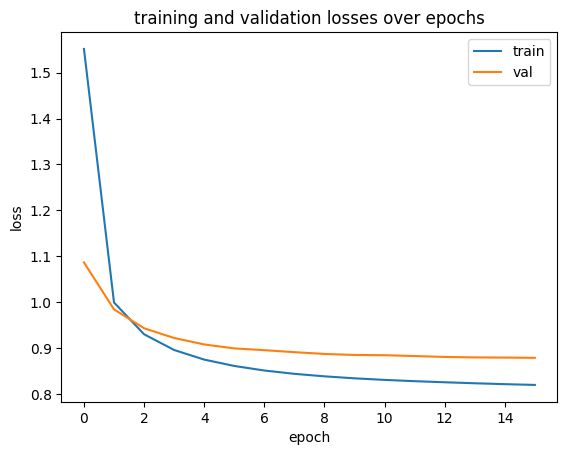

In [88]:
num_epochs = len(history.history["loss"])
plt.plot(range(num_epochs), history.history["loss"], label="train")
plt.plot(range(num_epochs), history.history["val_loss"], label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("training and validation losses over epochs")
plt.legend()
plt.show()

### Generate text

In [89]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(values=[-float('inf')]*len(skip_ids), indices=skip_ids, dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    predicted_logits, states = self.model(inputs=input_ids, states=states, return_state=True)
    
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    
    predicted_logits = predicted_logits + self.prediction_mask

    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    predicted_chars = self.chars_from_ids(predicted_ids)

    return predicted_chars, states

In [90]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars, temperature=0.75)

In [91]:
start = time.time()
states = None
next_char = tf.constant(['ජාතික'])
result = [next_char]

for n in range(1000):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('UTF-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ජාතික පක්ෂයේ නායක මහාචාර්ය ජී.එල් පීරිස් මහතා විසින් මෙම යෝජනාව පිළිබඳ විවාදයට ගැනීමට නියමිත බව වාර්තා වෙයි. කැබිනට් රැස්වීමේදී අදහස් දැක්වූ ශ්‍රී ලංකා නිදහස් පක්ෂයට එම කටයුතුවලට සම්බන්ධ බව ශ්‍රී ලංකා නීතීඥ සංගමය අද ප්‍රතිචාර දක්වා තිබේ. පාර්ලිමේන්තු මන්ත්‍රී විජිත හේරත් මහතා සිය ධුරයෙන් ඉල්ලා අස්වී තිබේ. මුහුණු ආවරණ නොගැනීම සම්බන්ධයෙන් ජනතාව දැනුවත් කිරීමේ අධිකාරියේ අනුමැතිය හිමිව තිබේ. ජනාධිපති ගෝඨාභය රාජපක්ෂ මහතා සිය අමාත්‍යාංශයේ පැවැති මාධ්‍ය හමුවකට එක්වෙමින් කරුණාරත්න පරිශ්‍රයේ පැවති විරෝධතාවය සහ විවිධ පාර්ශව සමග සාකච්ඡා කිරීමට සූදානම් බවය. පෙබරවාරි මස 20 වනදා පාර්ලිමේන්තුවේදී කථානායකවරයා විසින් පසුගියදා නිවේදනයක් නිකුත් කර තිබුණේ ප්‍රකාශිත ඡන්ද ප්‍රකාශ කිරීම, පැමිණිලි ලැබුණු බව වියට්නාම විද්‍යාඥවරුන්ගේ සංගමය අද (16) සිය වෘත්තීය සමිති ක්‍රියාමාර්ගය අඛණ්ඩව සිදුකරන බව පොලීසිය පැවසීය. ඒ අනුව නියෝජ්‍ය කතානායක මහින්ද යාපා අබේවර්ධන - පාර්ලිමේන්තු මන්ත්‍රී කනක හේරත් සහ රංජිත් සියඹලාපිටිය මහතා ඇතුළු පිරිසක් එක්විය. එක්සත් ජාතික පක්ෂ නායක රනිල් වික්‍රමසිංහ මහතා නිකුත් කළ නිවේදනයක මේ බව සඳහ

In [92]:
export_dir = "./saved_model"
tf.saved_model.save(one_step_model, export_dir=export_dir)

INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets
